# Recalibration loop in logistic regression

This notebook uses the simple breast cancer classification data set. We split the data into train and test sets. We then generate three synthetic test sets that demonstrate varying levels of mis-calibration. I am using a threshold of 0.5 to classify positives and negatives in this notebook because the data set is pretty well-balanced.

1. **Raw synthetic test set**: sample from the training set with replacement. Leave data as-is. Should be as well-calibrated as the train set because it is directly drawn from the training set.
2. **Experiment 1**: Constant offset test set. Take the raw synthetic set features and use the train (Site 1) model to generate the log odds. Then offset the log odds by a constant factor:
$$ \text{new log odds} = \alpha_0 + \text{log odds} $$
If the resulting probability is > 0.5, classify as a positive to create the new synthetic data. Leave features the same.
3. **Experiment 2**: Constant offset + multiplicative factor test set. Take the raw synthetic set features and use the train (Site 1) model to generate the log odds. Then offset the log odds by a constant factor and multiplicative factor:
$$ \text{new log odds} = \alpha_0 + \alpha_1 \times \text{log odds} $$
If the resulting probability is > 0.5, classify as a positive to create the new synthetic data. Leave features the same.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Read and process the data set

In [11]:
bc_data = load_breast_cancer()

In [12]:
print(bc_data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [13]:
features = pd.DataFrame(data=bc_data.data, 
                  columns=bc_data.feature_names)

In [14]:
features_std = pd.DataFrame()

Scale the features to prepare for analysis

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
features_std = pd.DataFrame(data=scaler.fit_transform(features),\
                            columns=features.columns)

In [18]:
labels = pd.DataFrame(data=bc_data['target'], columns=['target'])

In [19]:
labels.value_counts()

target
1         357
0         212
dtype: int64

The labels indicate whether the case is malignant (0) or benign (1). 

In [20]:
old_malignant = features[labels['target'] == 0].index
old_benign = features[labels['target'] == 1].index

I don't like this labeling scheme so I'm going to flip the labels so benign is 0 and malignant is 1.

In [21]:
labels.iloc[old_malignant] = 1
labels.iloc[old_benign] = 0

In [22]:
labels.value_counts()

target
0         357
1         212
dtype: int64

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(\
                        features_std, labels, test_size=0.25,\
                                         random_state=42)

## Create artificial test sets with discrimination and calibration problems

Rather than randomly splitting the data set, I will split using an artificial criterion to create some difference between the training set patient population and the target set, because this toy dataset is a relatively easy classification problem. I intentionally want a performance drop (still need to define that quantitatively) in the held-out data here, so that I can "fix" it using different strategies.

### Fit a L1-regularized logistic regression model to the training data as-is

In [25]:
sagaseed = 12 # seed for optimization

In [26]:
clf_gs = LogisticRegression(penalty='l1', tol=1e-4, C=1, fit_intercept=True,\
                                       random_state=sagaseed, solver='saga', max_iter=int(1e6));

In [27]:
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

In [28]:
param_grid = {'C' : [1e-2,1e-1,1e0,1e1,1e2]}

In [29]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=sagaseed+1)

In [30]:
gridsearch = GridSearchCV(clf_gs, param_grid, scoring='average_precision',\
                          cv=skf)

In [31]:
gridsearch.fit(x_train, y_train.to_numpy().ravel());

In [32]:
gridsearch.best_params_

{'C': 1.0}

In [33]:
clf = gridsearch.best_estimator_.fit(x_train, y_train.to_numpy().ravel()); # the numpy/ravel stuff shuts up a warning

Predict logit probabilities for the train and test set

In [34]:
y_train_proba = clf.predict_proba(x_train)[:,1]

In [35]:
y_test_proba = clf.predict_proba(x_test)[:,1]

## Making synthetic test data

Start by drawing samples from the train data with replacement. I want a data set that is closely related to the training set from which to create the synthetic data. I don't want a truly different test set, because I want to create synthetic test data with specific problems that can and can't be fixed with model recalibration.

The original logistic regression model is

$$ P(Y=1|\mathbf{x}) = \frac{1}{1+e^{-\beta_0 + \vec{\beta}\cdot\mathbf{x}}} $$

Let the risk score $z = \beta_0 + \vec{\beta_0}\cdot\mathbf{x}$

### Pull a synthetic test set from the train data

In [36]:
n_test_syn = len(x_test)
seed_syn = 222

In [37]:
x_test_syn = x_train.sample(n=n_test_syn, random_state=seed_syn, replace=True)
y_test_syn = y_train.loc[x_test_syn.index]

In [38]:
y_test_syn_proba = clf.predict_proba(x_test_syn)[:,1]

In [39]:
from sklearn.calibration import calibration_curve

In [40]:
xcal_test_syn, ycal_test_syn = calibration_curve(y_test_syn, y_test_syn_proba,n_bins=4)

In [41]:
xcal_train, ycal_train = calibration_curve(y_train, y_train_proba,n_bins=5)

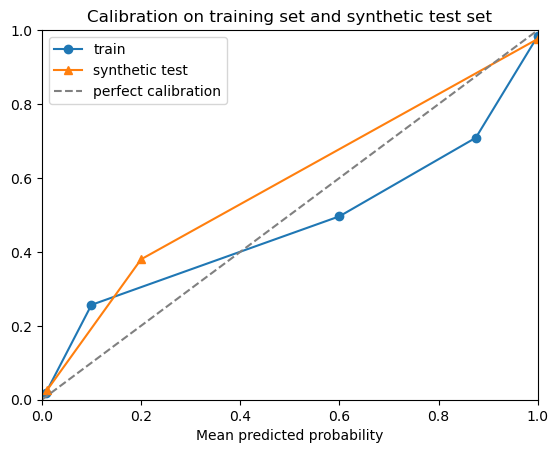

In [42]:
plt.plot(xcal_train, ycal_train,'o-', label='train')
plt.plot(xcal_test_syn, ycal_test_syn,'^-', label='synthetic test')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'--',color='gray', label='perfect calibration')
plt.title('Calibration on training set and synthetic test set')
plt.xlabel('Mean predicted probability')
plt.legend()
plt.show();

### Compute the Brier Score (MSE) 

In [43]:
from sklearn.metrics import brier_score_loss

In [44]:
print('Training set Brier Score (MSE) = {:.3f}'.format(\
                                brier_score_loss(y_train, y_train_proba)))

Training set Brier Score (MSE) = 0.013


In [45]:
print('Synthetic test set Brier Score (MSE) = {:.3f}'.format(\
                                brier_score_loss(y_test_syn, y_test_syn_proba)))

Synthetic test set Brier Score (MSE) = 0.013


They should certainly be close to one another, because the synthetic test is just redrawn from the train set here. Now let's mess with the synthetic test set to make data sets that the model is not well-calibrated on.

### Synthetic test 1 (constant offset to risk score)

What happens we adjust the probability by adding a constant offset $\alpha_0$ to the original risk score to generate synthetic data?

$$ P_1(Y=1|\mathbf{x}) = \frac{1}{1 + e^{-(\alpha_0 + z)}} $$

This will correspond to left and right translations of the probability vs. risk curve according to $\alpha_0$.

In [46]:
alpha0 = 3

Predicted probabilities based on risk scores from logistic regression

In [47]:
risk_train = clf.intercept_ + x_train @ clf.coef_.T
risk_test  = clf.intercept_ + x_test @ clf.coef_.T
risk_test_syn = clf.intercept_ + x_test_syn @ clf.coef_.T

In [48]:
y_test_syn_proba_1 = 1./(1. + np.exp(-alpha0 - risk_test_syn))

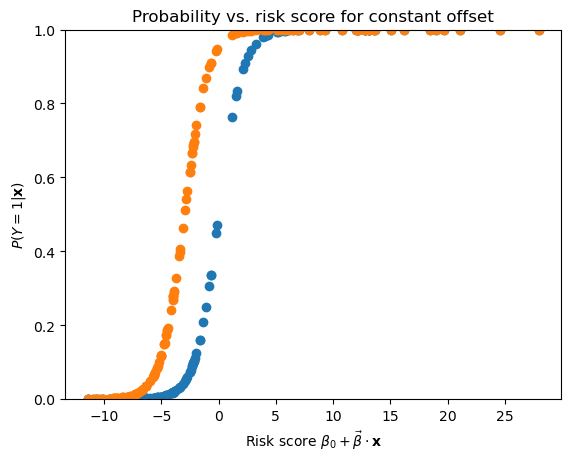

In [49]:
plt.plot(risk_test_syn, y_test_syn_proba, 'o')
plt.plot(risk_test_syn, y_test_syn_proba_1, 'o')
plt.xlabel(r'Risk score $\beta_0 + \vec{\beta} \cdot \mathbf{x}$')
plt.ylabel(r'$P(Y=1|\mathbf{x})$')
plt.title('Probability vs. risk score for constant offset')
plt.ylim(0,1);

Generate new labels for the synthetic test dataset and the offset one based on the risk score

In [50]:
y_test_syn = (y_test_syn > 0.5)

In [51]:
y_test_syn_1 = (y_test_syn_proba_1 > 0.5)

In [52]:
print('Prevalence in original synthetic test set = {:.2f}'.format(int(np.sum(y_test_syn))/len(y_test_syn)))
print('Prevalence in synthetic test set 1 = {:.2f}'.format(int(np.sum(y_test_syn_1))/len(y_test_syn_1)))

Prevalence in original synthetic test set = 0.32
Prevalence in synthetic test set 1 = 0.47


As expected, the offset changes the prevalence. But overall discrimination should be unchanged, as this doesn't reorder the probabilistic predictions in any way.

In [53]:
print('Synthetic test set 1 Brier Score (MSE) = {:.3f}'.format(\
                                brier_score_loss(y_test_syn_1, y_test_syn_proba)))

Synthetic test set 1 Brier Score (MSE) = 0.115


The MSE has now degraded because I messed up the calibration. Let's see if recalibration can fix this problem now.

### Adding multiplicative factor to $\vec{\beta}$

What happens we adjust the probability by adding a multiplicative factor $\alpha_1 > 0$ to the original risk score to generate synthetic data?

$$ P_1(Y=1|\mathbf{x}) = \frac{1}{1 + e^{-(\alpha_0 + \alpha_1 z)}} $$

This will correspond to making the probability curve more or less steep (more or less sharp transition)

In [54]:
alpha1 = 0.5

In [55]:
y_test_syn_proba_2 = 1./(1. + np.exp(-alpha0-alpha1*risk_test_syn))

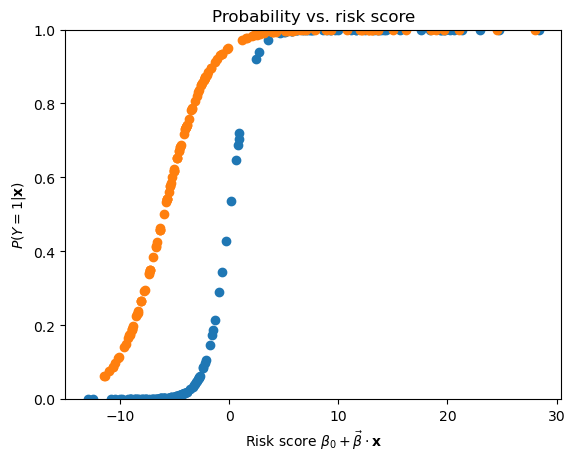

In [56]:
plt.plot(risk_test, y_test_proba, 'o')
#plt.plot(risk_test, y_test_syn_1, 'o')
plt.plot(risk_test_syn, y_test_syn_proba_2, 'o')
plt.xlabel(r'Risk score $\beta_0 + \vec{\beta} \cdot \mathbf{x}$')
plt.ylabel(r'$P(Y=1|\mathbf{x})$')
plt.title('Probability vs. risk score')
plt.ylim(0,1);

In [57]:
y_test_syn_2 = (y_test_syn_proba_2 > 0.5)

In [58]:
print('Prevalence in original synthetic test set = {:.2f}'.format(int(np.sum(y_test_syn))/len(y_test_syn)))
print('Prevalence in synthetic test set 2 = {:.2f}'.format(int(np.sum(y_test_syn_2))/len(y_test_syn_2)))

Prevalence in original synthetic test set = 0.32
Prevalence in synthetic test set 2 = 0.72


In [59]:
print('Synthetic test set 2 Brier Score (MSE) = {:.3f}'.format(\
                                brier_score_loss(y_test_syn_2, y_test_syn_proba)))

Synthetic test set 2 Brier Score (MSE) = 0.360


As expected, this perturbation of the probabilities also degrades the calibration. Now we have two synthetic test sets, with Brier scores of

- **Synthetic test set 0**: MSE = 0.013 (RMSE = 0.114)
- **Synthetic test set 1 (constant offset)**: MSE = 0.115 (RMSE=0.339)
- **Synthetic test set 2 (scaled offset)**: MSE = 0.147 (RMSE=0.383)

## Recalibration tests in synthetic data sets

Now let's use the two synthetic data sets with different mis-calibration issues to test and then recalibrate if needed. For simplicity right now, I'm going to use the Brier score as the only metric for assessing the data set calibration.

Start by sampling possible data from the test synthetic data set and checking the calibration

### Test 1: constant offset

In [60]:
new_bs = 1. # initialize the Brier score
n_sample_add = 10 # number of samples to add on each step
brier_score_eps = 0.005 # MSE can be higher than brier_score_cal by this amount
brier_score_cal = 0.013
all_idx = y_test_syn.index.to_list()
sample_idx = [] # array of sample indices 

while (new_bs > brier_score_cal + brier_score_eps)\
  and len(sample_idx) < len(y_test_syn_1) - n_sample_add:
    # obtain the new samples
    np.random.seed(2727)
    idx_new = np.random.choice(all_idx, size=n_sample_add, replace=False)
    for i in idx_new:
        all_idx.remove(i)
    sample_idx += list(idx_new)
    print('Drawing {} samples'.format(len(sample_idx)))
    y_test_these = y_test_syn_1.loc[sample_idx]
    x_test_these = x_test_syn.loc[sample_idx]
    
    # calculate probability for these samples from current model
    y_test_these_proba = clf.predict_proba(x_test_these)[:,1]

    # test brier score calibration
    bs = brier_score_loss(y_test_these, y_test_these_proba)
    print('Brier score = {:.3f}'.format(bs))
    
    if bs > (brier_score_cal + brier_score_eps):
        # recalibrate and try again
        clf_recal = LogisticRegression()
        risk_scores_these = clf.intercept_ + x_test_these @ clf.coef_.T
        clf_recal.fit(risk_scores_these, y_test_these.to_numpy().ravel())
        a0 = clf_recal.intercept_[0]
        a1 = clf_recal.coef_[0][0]
        print('alpha_0 = {:.3f}, alpha_1 = {:.3f}'.format(a0, a1))
        new_proba = 1./(1. + np.exp(-a0 - a1*(risk_scores_these)))
        new_bs = brier_score_loss(y_test_these, new_proba)
        print('> New Brier score = {:.3f}\n'.format(new_bs))

Drawing 10 samples
Brier score = 0.063
alpha_0 = 2.199, alpha_1 = 1.057
> New Brier score = 0.026

Drawing 20 samples
Brier score = 0.033
alpha_0 = 2.404, alpha_1 = 1.144
> New Brier score = 0.013



For the offset data set, we end up with

$$ \text{new log odds} = 2.404 + 1.144 (\text{log odds})$$

After drawing 20 new samples from the synthetic data set. The true model used to generated the synthetic data was

$$ \text{new log odds} = 3 + 1.0 (\text{log odds})$$

### Test 2: multiplicative factor

In [61]:
new_bs = 1. # initialize the Brier score
n_sample_add = 10 # number of samples to add on each step
brier_score_eps = 0.001 # MSE can be higher than brier_score_cal by this amount
brier_score_cal = 0.013
all_idx = y_test_syn.index.to_list()
sample_idx = [] # array of sample indices 

while (new_bs > brier_score_cal + brier_score_eps)\
  and len(sample_idx) < len(y_test_syn_2) - n_sample_add:
    # obtain the new samples
    np.random.seed(2728)
    idx_new = np.random.choice(all_idx, size=n_sample_add, replace=False)
    for i in idx_new:
        all_idx.remove(i)
    sample_idx += list(idx_new)
    print('Drawing {} samples'.format(len(sample_idx)))
    y_test_these = y_test_syn_2.loc[sample_idx]
    x_test_these = x_test_syn.loc[sample_idx]
    
    # calculate probability for these samples from current model
    y_test_these_proba = clf.predict_proba(x_test_these)[:,1]

    # test brier score calibration
    bs = brier_score_loss(y_test_these, y_test_these_proba)
    print('Brier score = {:.3f}'.format(bs))
    
    if bs > (brier_score_cal + brier_score_eps):
        # recalibrate and try again
        clf_recal = LogisticRegression()
        risk_scores_these = clf.intercept_ + x_test_these @ clf.coef_.T
        clf_recal.fit(risk_scores_these, y_test_these.to_numpy().ravel())
        a0 = clf_recal.intercept_[0]
        a1 = clf_recal.coef_[0][0]
        print('alpha_0 = {:.3f}, alpha_1 = {:.3f}'.format(a0, a1))
        new_proba = 1./(1. + np.exp(-a0 - a1*(risk_scores_these)))
        new_bs = brier_score_loss(y_test_these, new_proba)
        print('> New Brier score = {:.3f}\n'.format(new_bs))

Drawing 10 samples
Brier score = 0.282
alpha_0 = 7.654, alpha_1 = 1.325
> New Brier score = 0.015

Drawing 20 samples
Brier score = 0.383
alpha_0 = 11.444, alpha_1 = 1.861
> New Brier score = 0.009

